In [1]:
import matplotlib.pyplot as plt
from itertools import combinations
from random import random,randint
import numpy as np
from functools import reduce
from scipy.optimize import minimize
from scipy.linalg import expm,sinm,cosm
from sympy import *
import time
import math
from   matplotlib import cm
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.quantum_info.analysis import average_data
from qiskit import *
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.utils import tensorproduct
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram
import picos as pic
import warnings
from docplex.mp.model import Model
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import CplexOptimizer
import scipy.linalg as la
from itertools import permutations, combinations
from numpy.linalg import inv
from decimal import *


In [2]:
def num_1_pos(d):
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    num_1 = get_indexes(1,d)
    return num_1,len(num_1)

def num_0_pos(d):
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    num_0 = get_indexes(0,d)
    return num_0,len(num_0)

def column(matrix, i):
    return [row[i] for row in matrix]

#Construct initial state 
def init_s(n):
    x = pow(2,n)
    s = 1/np.sqrt(x) * np.ones(x)
    s = s.reshape(x, 1)
    return s

def bin2dec(string_num):
    return str(int(string_num, 2))

def row_binary(v):
    for i in range(len(v)):
        if v[i]%2 == 0:
            v[i] = 0
        else:
            v[i] = 1 
    return v

def converter(d):
    P = 0
    for i in range(len(d)):
        P+=d[i]*(2**(len(d)-i-1))
    return P
                 
#Define some pauli operators
PauliX = [[0,1],[1,0]]   
PauliZ = [[1,0],[0,-1]]
PauliI = np.eye(2)

#Define Cjk and B
def Cjk_generator(d):
    n = len(d)
    l = list(range(0,n))    
    for i in range(n):
        l[i] = PauliI
    s = num_1_pos(d)[0]
    for j in range(len(s)):
        l[s[j]] = PauliZ
    Cjk = l[0]
    for i in range(n-1):
        Cjk = np.kron(Cjk,l[i+1])
    return Cjk

def B_generator(n):
    l = list(range(0,n))
    b = list(range(0,n))
    
    for a in range(n):
        for i in range(n):
            l[i] = PauliI
        l[a]=PauliX
        temp = l[0]
        for i in range(n-1):
            temp = np.kron(temp,l[i+1])
        b[a] = temp
    B = sum(b[a] for a in range(n))
    return B

def basis(n):
    nums = np.array([a for a in range(2**(n))]) 
    bin_nums = (((nums.reshape(-1,1) & (2**np.arange(n)))) != 0).astype(int)
    a = bin_nums[:,::-1]
    return a


def matrix_binary(A):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i][j]%2 == 0:
                A[i][j] = 0
            else:
                A[i][j] = 1
    return A

def z_gen(syndr,H):
    z = []
    for w in range((H.shape[1]-len(syndr))):
        z.append(0)
    for a in range(len(syndr)):
        z.append(syndr[a])
    return z
def err(n,t):
    err = []
    for a in range(n):
        err.append(0)
    err[t] = 1
    return err

def conv(nums):
    n = len(nums)
    dec = 0
    for i in range(n):
        dec += nums[i]*(2**(n-i-1))
    return dec

def cal(A,R):
    R_T = R.T
    coef = []
    for i in range(A.shape[0]):
        a = A[i]
        coef.append("Row:{}".format(i+1))
        for k in range(A.shape[1]):
            b = R_T[k]
            temp = []
            for j in range(len(a)):
                temp.append(a[j]*b[j])
            coef.append(temp)
    return coef

def cals(A,R):
    R_T = R.T
    coef = []
    for i in range(A.shape[0]):
        a = A[i]
        #coef.append("Row:{}".format(i+1))
        tem = []
        for k in range(A.shape[1]):
            b = R_T[k]
            temp = []
            for j in range(len(a)):
                temp.append(a[j]*b[j])
            te = []
            te.append(temp[0])
            e = sum(temp[1:int(len(temp)/2)])
            f = sum(temp[int(len(temp)/2):int(len(temp))-1])
            te.append(e)
            te.append(f)
            te.append(temp[-1])
            tem.append(te)
        coef.append(tem)
    return coef

def cals1(A,R):
    R_T = R.T
    coef = []
    for i in range(A.shape[0]):
        a = A[i]
        coef.append("Row:{}".format(i+1))
        tem = []
        for k in range(A.shape[1]):
            b = R_T[k]
            temp = []
            for j in range(len(a)):
                temp.append(a[j]*b[j])
            te = []
            te.append(temp[0])
            e = sum(temp[1:int(len(temp)/2)])
            f = sum(temp[int(len(temp)/2):int(len(temp))-1])
            te.append(e)
            te.append(f)
            te.append(temp[-1])
            tem.append(te)
        coef.append(tem)
    return coef





    
    

In [ ]:
''''n = 4
B = B_generator(n)
print(B)
M = Matrix(B) 
P, D = M.diagonalize()   

Diag = np.array(D)
print(Diag)
U = np.array(P)
U = U.astype(np.float)

print('U:',U)
Uinv = inv(U)
print('Uinv:',Uinv*(2**n))
J = (U.dot(Diag)).dot(Uinv)
J = np.double(J)
print('J:',np.around(J, decimals = 1))'''



In [4]:
# g = cals(U,Uinv*(2**n))
# h = cals1(U,Uinv*(2**n))
# print(h)

In [5]:
# def calcu(g):
#     b = []
#     for j in range(len(g[0])): 
#         a = np.zeros(len(g[0][0]))
#         for i in range(len(g[0])):
#             a += np.array(g[i][j])
#         b.append(a)
#     return b

# s = calcu(g)

# print(np.around(s, decimals = 1))

In [3]:
G_oringin = np.array([[1,0,0,0,1,1,0],
              [0,1,0,0,1,0,1],
              [0,0,1,0,0,1,1],
              [0,0,0,1,1,1,1]])
G_oringinT = G_oringin.T
H = np.array([[1,1,0,1,1,0,0],
              [1,0,1,1,0,1,0],
              [0,1,1,1,0,0,1]])
HT = H.T


In [4]:
C = sum(Cjk_generator(G_oringinT[a]) for a in range(G_oringinT.shape[0]))
print(C)

[[ 7.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. 

# Syndrome

# Oringinal with one bit error

syndrome: [1 1 0]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 1, 1, 0]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 1]


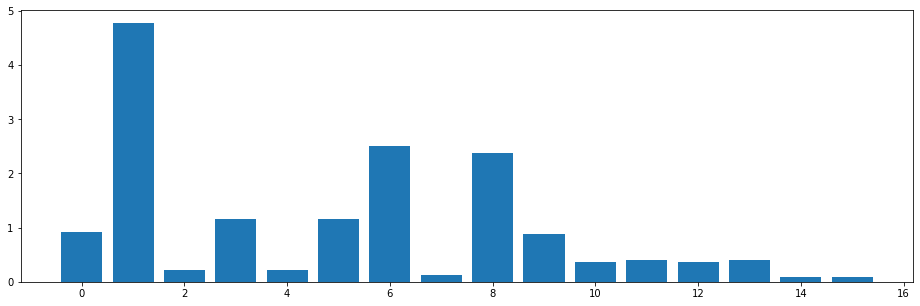

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 1, 0, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 1 0]


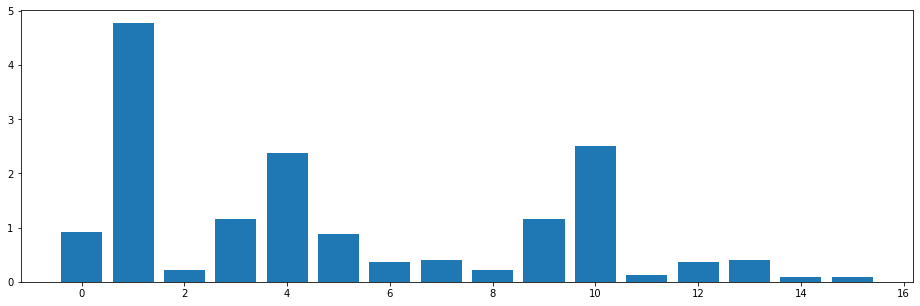

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 1 0 0]


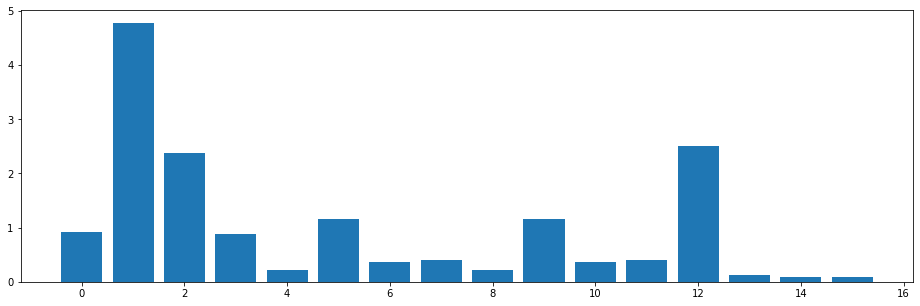

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 1 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 1, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0]


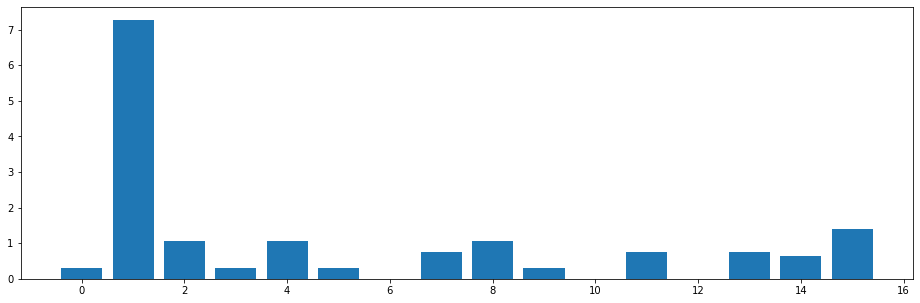

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 0]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0]


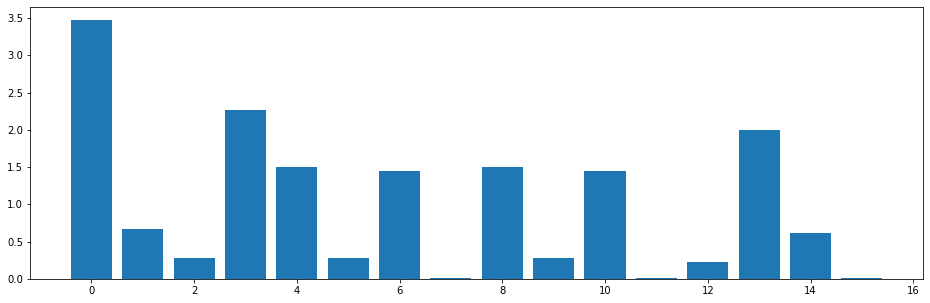

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 0]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0]


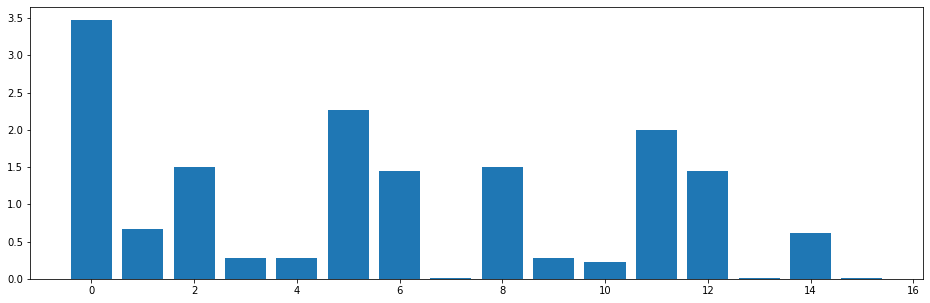

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 0 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1]


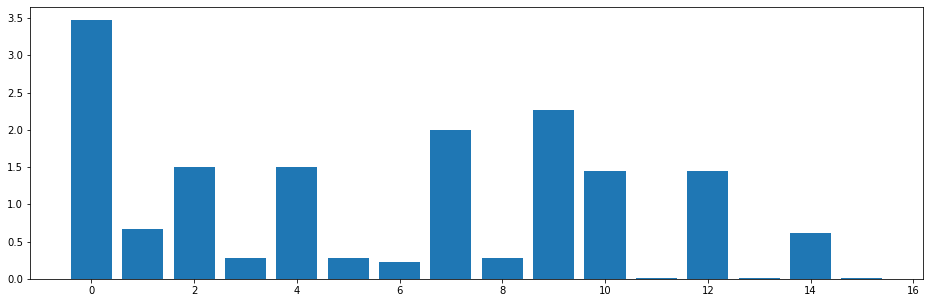

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
correcting rate: 57.14285714285714


In [8]:
u = 0
for t in range(HT.shape[0]):    
    syndr = HT[t]
    n = G_oringin.shape[0]
    
    message = basis(n)[0]
    print('syndrome:',syndr)
    print('message:',message)
    z = z_gen(syndr,H)
    print("z = ",z)
    C = sum((1-2*z[a])*Cjk_generator(G_oringinT[a]) for a in range(G_oringinT.shape[0]))
    B = B_generator(G_oringinT.shape[1])
    s = init_s(n)
    s_d = (s).T
    #print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    step_size   = 0.05
    result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
    a_gamma         = np.arange(0, np.pi, step_size)
    a_beta          = np.arange(0, np.pi, step_size)
    #print("Numbers of iteration: ",(pow((int(3.14/step_size)+1),2)))
    f_p_max = 0
    f_p_max_gamma = 0
    f_p_max_beta = 0
    f_psum = 0

    for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
        for j in range(0, int(3.14/step_size)+1):       # j for a_beta

            #Construct U_C
            U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
            #Construct U_B
            U_B = expm(-1j*a_beta[j]*B)


            #Construct expection of each subgraph
            state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
            state_d = (state.conjugate()).T # bra


            f_p = (state_d.dot(C)).dot(state)
            f_psum += f_p


            if f_p.real > f_p_max:
                f_p_max = f_p.real
                f_p_max_gamma = a_gamma[i]
                f_p_max_beta = a_beta[j]

            result_array[i][j] = f_p.real
    #         print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
    #         print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
    #         print("\n Optimal gamma : ",f_p_max_gamma)
    #         print("\n Optimal beta : ",f_p_max_beta)


    end_time = time.time()
    #print("\n Runningtime : ",end_time - start_time)
    c = converter(message)
    r = np.ones(2**len(message))

    #Construct U_C
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)


    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))      
    e = np.max(prob)
    q = int(np.where(prob==np.max(prob))[0])
    print("most likey basis:  ",q)
    #     if int(k+1) != int(np.where(prob==np.max(prob))[0]+1):
    #         print("CANNOT correct！！！！！！")
    #     else:
    #         print("Good Job!!!!!!")
    #         u+=1
    em= basis(n)[q]
    print('estimate message:',em)
    error = row_binary(np.array(em).dot(G_oringin)+np.array(z))
    print('error:',error)
    plt.rcParams['figure.figsize'] = [16, 5]
    plt.bar(range(0, len(state)),prob)
    plt.show()
    if conv(err(HT.shape[0],t)) == conv(error):
        u+=1
    print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
print('correcting rate:',u/(t+1)*100)

# Apply QAOA twice

syndrome: [1 1 0]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 1, 1, 0]

 Optimal gamma :  0.1 2.2

 Optimal beta :  0.5 0.4

 Runningtime :  1465.472639799118
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0]


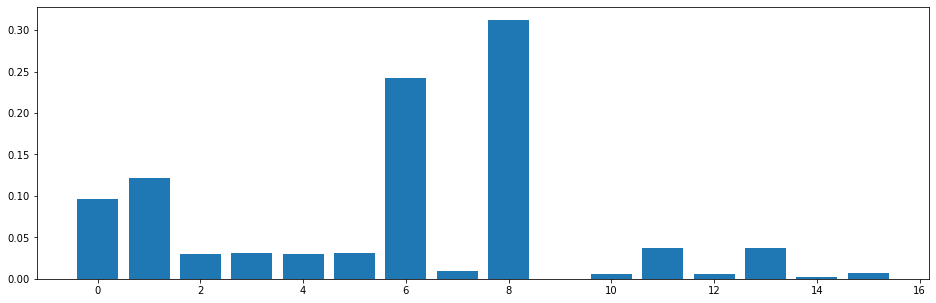

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 1, 0, 1]

 Optimal gamma :  0.1 2.2

 Optimal beta :  0.5 0.4

 Runningtime :  1452.7834084033966
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0]


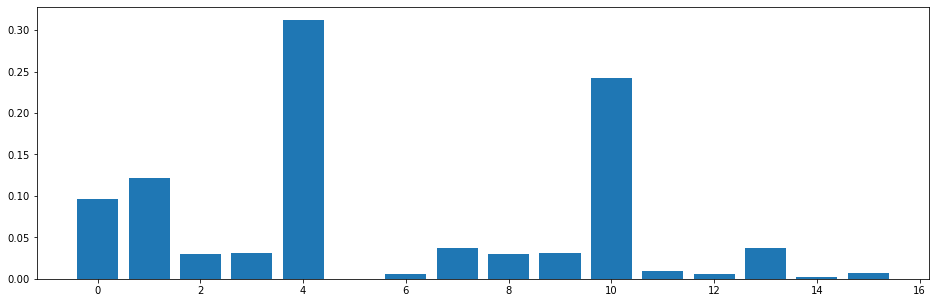

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 0, 1, 1]

 Optimal gamma :  0.1 2.2

 Optimal beta :  0.5 0.4

 Runningtime :  1455.4138345718384
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0]


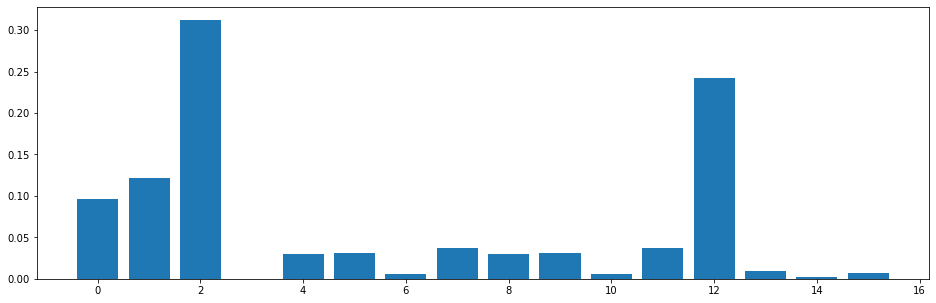

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 1 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 1, 1, 1]

 Optimal gamma :  2.6 1.8

 Optimal beta :  2.6 0.4

 Runningtime :  1446.1580624580383
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0]


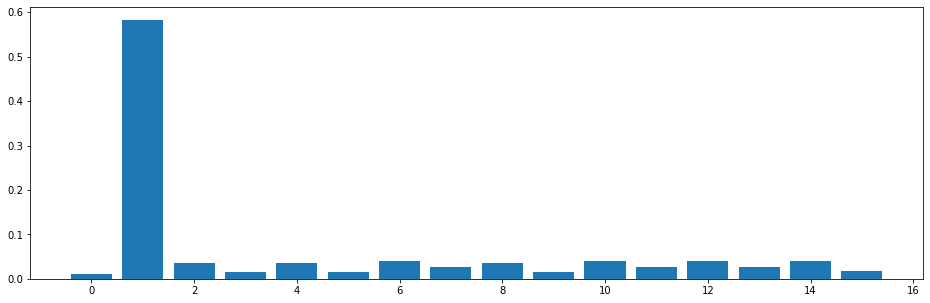

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 0]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 1, 0, 0]

 Optimal gamma :  3.0 0.2

 Optimal beta :  2.1 0.4

 Runningtime :  1458.1607325077057
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0]


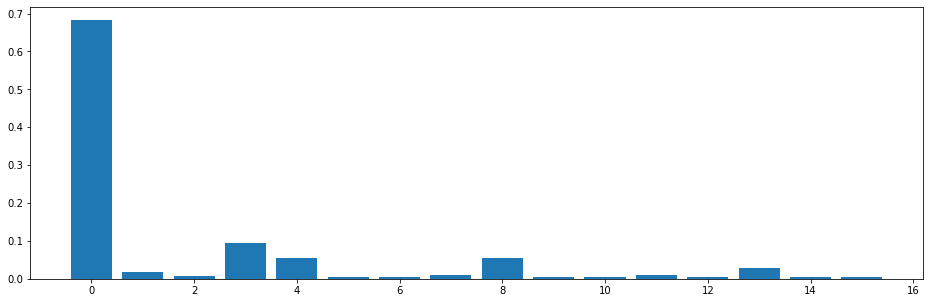

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 0]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 0, 1, 0]

 Optimal gamma :  3.0 0.2

 Optimal beta :  2.1 0.4

 Runningtime :  1458.507708787918
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0]


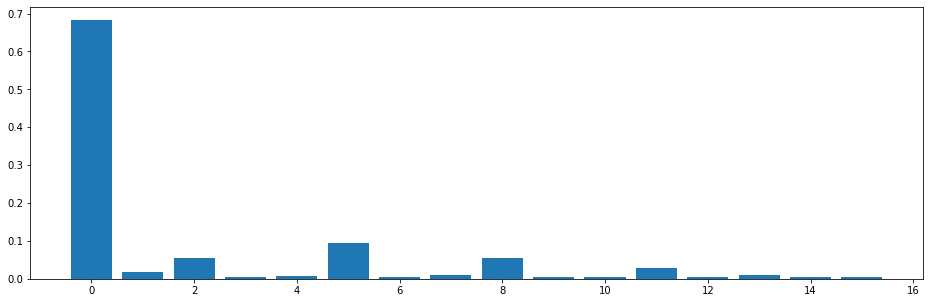

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 0 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 0, 0, 1]

 Optimal gamma :  3.0 0.2

 Optimal beta :  2.1 0.4

 Runningtime :  1460.355481147766
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1]


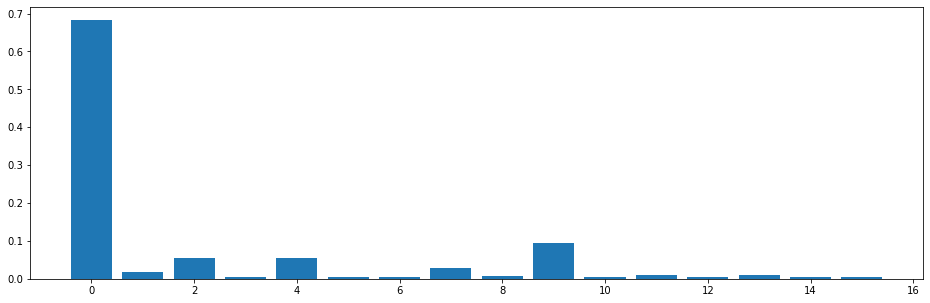

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
correcting rate: 100.0


In [5]:
u = 0
for t in range(HT.shape[0]):    
    syndr = HT[t]
    n = G_oringin.shape[0]
    
    message = basis(n)[0]
    print('syndrome:',syndr)
    print('message:',message)
    z = z_gen(syndr,H)
    print("z = ",z)
    C = sum((1-2*z[a])*Cjk_generator(G_oringinT[a]) for a in range(G_oringinT.shape[0]))
    B = B_generator(G_oringinT.shape[1])
    s = init_s(n)
    s_d = (s).T
    #print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    step_size   = 0.1
    result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1,int(3.14/step_size)+1, int(3.14/step_size)+1))
    a_gamma1         = np.arange(0, np.pi, step_size)
    a_beta1          = np.arange(0, np.pi, step_size)
    a_gamma2         = np.arange(0, np.pi, step_size)
    a_beta2          = np.arange(0, np.pi, step_size)
    #print("Numbers of iteration: ",(pow((int(3.14/step_size)+1),2)))
    f_p_max = 0
    f_p_max_gamma1 = 0
    f_p_max_beta1 = 0
    f_p_max_gamma2 = 0
    f_p_max_beta2 = 0
    f_psum = 0

    
    for m in range(0, int(3.14/step_size)+1):           # i for a_gamma
        for l in range(0, int(3.14/step_size)+1): 
            for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
                for j in range(0, int(3.14/step_size)+1):       # j for a_beta
                    
                    #Construct U_C1
                    U_C1 = np.asmatrix(expm(-1j*2*a_gamma1[i]*C))
                    #Construct U_B1
                    U_B1 = expm(-1j*a_beta1[j]*B)
                    #Construct U_C2
                    U_C2 = np.asmatrix(expm(-1j*2*a_gamma2[m]*C))
                    #Construct U_B3
                    U_B2 = expm(-1j*a_beta2[n]*B)


                    #Construct expection of each subgraph
                    state = (U_B2.dot(U_C2)).dot((U_B1.dot(U_C1)).dot(s)).reshape(pow(2,n),1) # ket
                    state_d = (state.conjugate()).T # bra


                    f_p = (state_d.dot(C)).dot(state)
                    f_psum += f_p


                    if f_p.real > f_p_max:
                        f_p_max = f_p.real
                        f_p_max_gamma1 = a_gamma1[i]
                        f_p_max_beta1 = a_beta1[j]
                        f_p_max_gamma2 = a_gamma2[m]
                        f_p_max_beta2 = a_beta2[n]
                    result_array[i][j][m][n] = f_p.real
            #         print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
            #         print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
    print("\n Optimal gamma : ",f_p_max_gamma1 , f_p_max_gamma2)
    print("\n Optimal beta : ",f_p_max_beta1 ,f_p_max_beta2)
                    
    end_time = time.time()
    
    
    print("\n Runningtime : ",end_time - start_time)
    
    
    c = converter(message)
    r = np.ones(2**len(message))

    #Construct U_C
    U_C1 = np.asmatrix(expm(-1j*2*f_p_max_gamma1*C))
    U_C2 = np.asmatrix(expm(-1j*2*f_p_max_gamma2*C))
    #Construct U_B
    U_B1 = expm(-1j*f_p_max_beta1*B)
    U_B2 = expm(-1j*f_p_max_beta2*B)



    #Construct expection of each subgraph
    state = (U_B2.dot(U_C2)).dot((U_B1.dot(U_C1)).dot(s)).reshape(pow(2,n),1) # ket
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))      
    e = np.max(prob)
    q = int(np.where(prob==np.max(prob))[0])
    print("most likey basis:  ",q)
    #     if int(k+1) != int(np.where(prob==np.max(prob))[0]+1):
    #         print("CANNOT correct！！！！！！")
    #     else:
    #         print("Good Job!!!!!!")
    #         u+=1
    em= basis(n)[q]
    print('estimate message:',em)
    error = row_binary(np.array(em).dot(G_oringin)+np.array(z))
    print('error:',error)
    plt.rcParams['figure.figsize'] = [16, 5]
    plt.bar(range(0, len(state)),prob)
    plt.show()
    if conv(err(HT.shape[0],t)) == conv(error):
        u+=1
    print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
print('correcting rate:',u/(t+1)*100)

In [7]:
z = [0, 0, 0, 0, 1, 1, 0]
error = row_binary(basis(4)[8].dot(G_oringin)+np.array(z))
print(error)


[1 0 0 0 0 0 0]


# Apply a full rank matrix on G

In [6]:
P = np.array([[1,0,0,0],
              [0,1,1,0],
              [0,1,1,1],
              [1,1,0,1]])
print(np.linalg.matrix_rank(P))
G = matrix_binary(P.dot(G_oringin))
GT = G.T
print(G)
print(GT)

4
[[1 0 0 0 1 1 0]
 [0 1 1 0 1 1 0]
 [0 1 1 1 0 0 1]
 [1 1 0 1 1 0 0]]
[[1 0 0 1]
 [0 1 1 1]
 [0 1 1 0]
 [0 0 1 1]
 [1 1 0 1]
 [1 1 0 0]
 [0 0 1 0]]


syndrome: [1 1 0]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 1, 1, 0]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0]


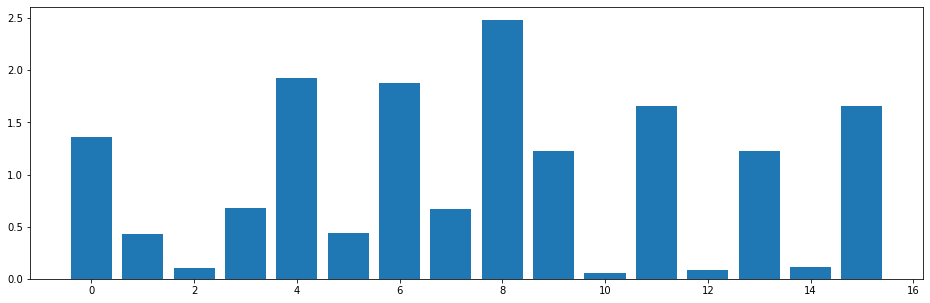

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 1, 0, 1]
most likey basis:   15
estimate message: [1 1 1 1]
error: [0 1 0 0 0 0 0]


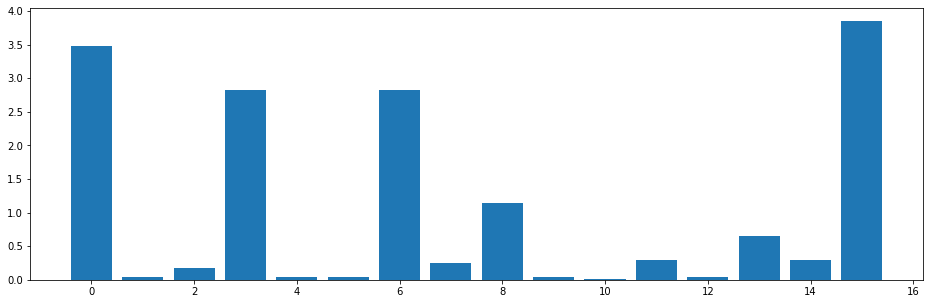

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 0, 1, 1]
most likey basis:   11
estimate message: [1 0 1 1]
error: [0 0 1 0 0 0 0]


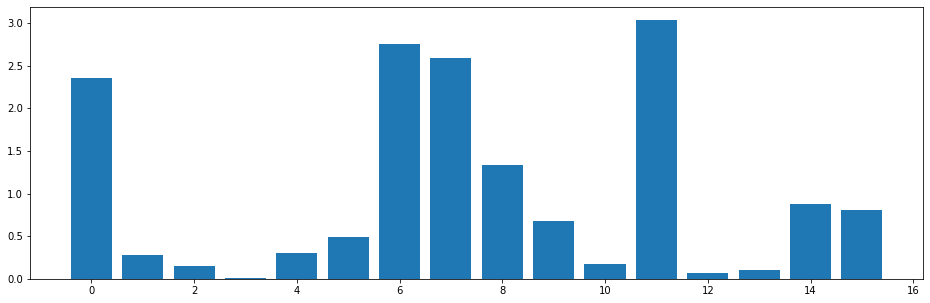

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 1 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 1, 1, 1]
most likey basis:   6
estimate message: [0 1 1 0]
error: [0 0 0 1 0 0 0]


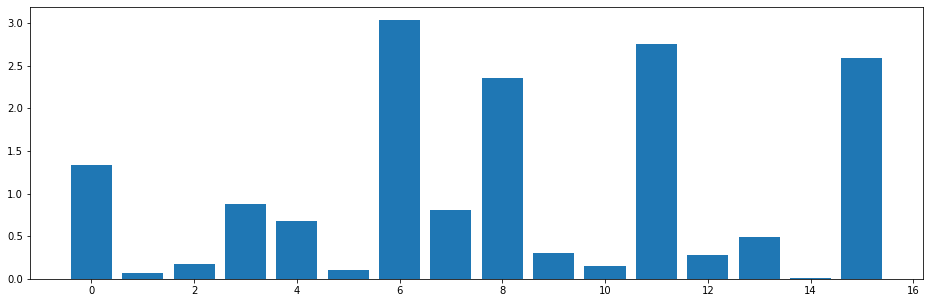

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 0]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0]


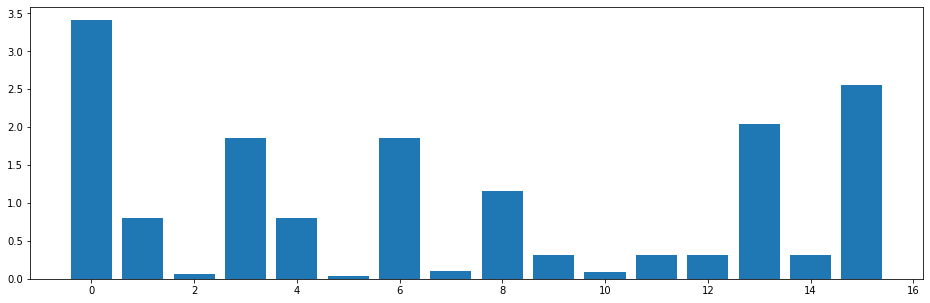

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 0]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0]


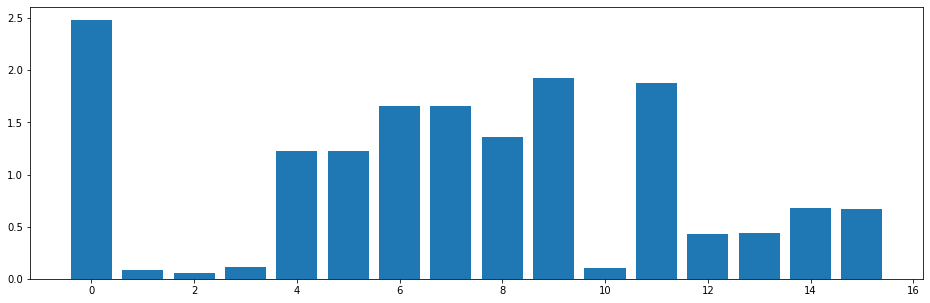

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 0 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1]


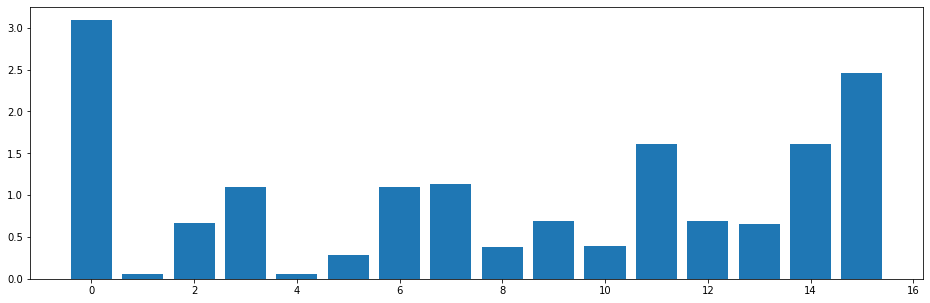

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
correcting rate: 100.0


In [8]:
u = 0
for t in range(HT.shape[0]):    
    syndr = HT[t]
    n = G.shape[0]
    message = basis(n)[0]
    print('syndrome:',syndr)
    print('message:',message)
    z = z_gen(syndr,H)
    print("z = ",z)
    C = sum((1-2*z[a])*Cjk_generator(GT[a]) for a in range(GT.shape[0]))
    B = B_generator(GT.shape[1])
    s = init_s(n)
    s_d = (s).T
    #print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    step_size   = 0.05
    result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
    a_gamma         = np.arange(0, np.pi, step_size)
    a_beta          = np.arange(0, np.pi, step_size)
    #print("Numbers of iteration: ",(pow((int(3.14/step_size)+1),2)))
    f_p_max = 0
    f_p_max_gamma = 0
    f_p_max_beta = 0
    f_psum = 0

    for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
        for j in range(0, int(3.14/step_size)+1):       # j for a_beta

            #Construct U_C
            U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
            #Construct U_B
            U_B = expm(-1j*a_beta[j]*B)


            #Construct expection of each subgraph
            state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
            state_d = (state.conjugate()).T # bra


            f_p = (state_d.dot(C)).dot(state)
            f_psum += f_p


            if f_p.real > f_p_max:
                f_p_max = f_p.real
                f_p_max_gamma = a_gamma[i]
                f_p_max_beta = a_beta[j]

            result_array[i][j] = f_p.real
    #         print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
    #         print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
    #         print("\n Optimal gamma : ",f_p_max_gamma)
    #         print("\n Optimal beta : ",f_p_max_beta)


    end_time = time.time()
    #print("\n Runningtime : ",end_time - start_time)
    c = converter(message)
    r = np.ones(2**len(message))

    #Construct U_C
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)


    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))      
    e = np.max(prob)
    q = int(np.where(prob==np.max(prob))[0])
    print("most likey basis:  ",q)
    #     if int(k+1) != int(np.where(prob==np.max(prob))[0]+1):
    #         print("CANNOT correct！！！！！！")
    #     else:
    #         print("Good Job!!!!!!")
    #         u+=1
    em= basis(n)[q]
    print('estimate message:',em)
    error = row_binary(np.array(em).dot(G)+np.array(z))
    print('error:',error)
    plt.rcParams['figure.figsize'] = [16, 5]
    plt.bar(range(0, len(state)),prob)
    plt.show()
    if conv(err(HT.shape[0],t)) == conv(error):
        u+=1
    print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
print('correcting rate:',u/(t+1)*100)